In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, adjusted_rand_score
from scipy.stats import mode

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mnist = fetch_openml("mnist_784", version=1)
X = mnist.data / 255.0
y = mnist.target.astype(int)

train_samples = 20000
test_samples = 20000

X_train_raw = X[:train_samples]
y_train = y[:train_samples]

X_test_raw = X[train_samples:train_samples + test_samples]
y_test = y[train_samples:train_samples + test_samples]

pca = PCA(n_components=50)

scaler = MinMaxScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

X_train = pca.fit_transform(X_train_raw)
X_test = pca.transform(X_test_raw)

In [79]:
from tqdm import trange
from scipy.special import loggamma as gammaln

class StudentTMixtureModel:
    def __init__(self, n_components=10, max_iter=50, tol=1e-4, verbose=True, nu=5):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.nu = nu  # degrees of freedom (can be made learnable too)

    def _student_t_log_pdf(self, x, mu, var):
        D = x.shape[1]
        nu = self.nu
        diff = x - mu
        inv_var = 1.0 / var
        quad_form = np.sum(diff**2 * inv_var, axis=1)
        log_det = np.sum(np.log(var + 1e-10))
        log_prob = (
            gammaln((nu + D) / 2)
            - gammaln(nu / 2)
            - 0.5 * log_det
            - (D / 2) * np.log(nu * np.pi)
            - ((nu + D) / 2) * np.log(1 + quad_form / nu)
        )

        return log_prob

    def _e_step(self, X):
        N, D = X.shape
        log_resp = np.zeros((N, self.K))
        for k in range(self.K):
            log_pdf = self._student_t_log_pdf(X, self.mu[k], self.var[k])
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf

        max_log_resp = np.max(log_resp, axis=1, keepdims=True)
        resp = np.exp(log_resp - max_log_resp)
        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def _m_step(self, X, resp):
        N, D = X.shape
        Nk = resp.sum(axis=0)
        self.pi = Nk / N

        for k in range(self.K):
            r_k = resp[:, k][:, None]
            mu_k = np.sum(r_k * X, axis=0) / Nk[k]
            diff = X - mu_k
            sigma2_k = np.sum(r_k * diff**2, axis=0) / Nk[k]
            self.mu[k] = mu_k
            self.var[k] = np.clip(sigma2_k, 1e-3, None)

    def fit(self, X):
        N, D = X.shape
        from sklearn.cluster import KMeans
        km = KMeans(n_clusters=self.K, init='k-means++', n_init=10).fit(X)
        self.mu = km.cluster_centers_
        self.var = np.ones((self.K, D))
        self.pi = np.ones(self.K) / self.K
        self.loss_history = []

        progress = trange(self.max_iter, desc="Training TMM", leave=True)
        for i in progress:
            resp = self._e_step(X)
            self._m_step(X, resp)

            if self.verbose:
                log_likelihood = np.sum(np.log(np.sum([
                    self.pi[k] * np.exp(self._student_t_log_pdf(X, self.mu[k], self.var[k]))
                    for k in range(self.K)
                ], axis=0) + 1e-10))
                self.loss_history.append(log_likelihood)
                progress.set_description(f"Iter {i+1} | LogL: {log_likelihood:.2f}")

        self.resp = resp
        
    def plot_components(self, pca, title = 'TMM Component Means'):
        imgs = pca.inverse_transform(self.mu)
        n_cols = 10
        n_rows = (self.K + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(1 * n_cols, 1 * n_rows))
        axes = axes.flatten()

        for k in range(self.K):
            axes[k].imshow(imgs[k].reshape(28, 28), cmap='gray')
            axes[k].axis('off')

        for k in range(self.K, len(axes)):
            axes[k].axis('off')

        plt.suptitle(title, fontsize=12)
        plt.tight_layout()
        plt.subplots_adjust(top=0.80)
        plt.show()

    def predict(self, X):
        log_resp = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + self._student_t_log_pdf(X, self.mu[k], self.var[k])
        return np.argmax(log_resp, axis=1)

    def plot_loss(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.title("TMM Log-Likelihood Loss History")
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.grid()
        plt.show()

Iter 50 | LogL: -444642.77: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it]



Mapped Clustering Accuracy (TMM): 81.92%
Adjusted Rand Index (ARI): 0.6712


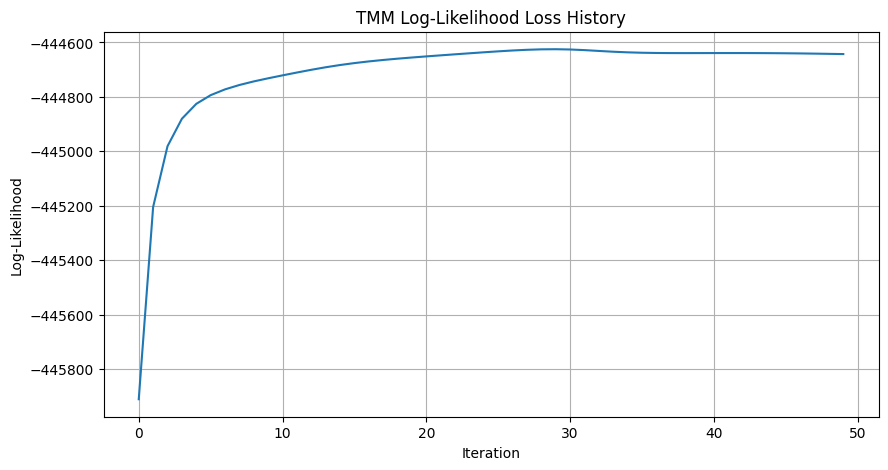

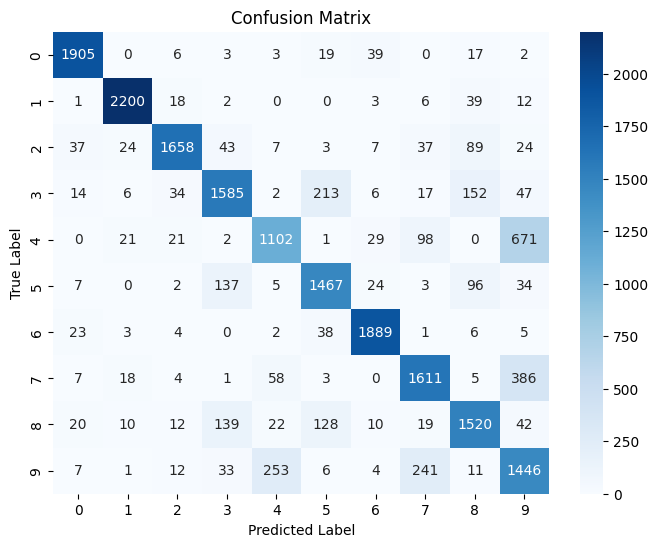

In [80]:
# Train TMM
tmm = StudentTMixtureModel(n_components=50, max_iter=50, verbose=True)
tmm.fit(X_train)

# Predict clusters
y_pred = tmm.predict(X_train)

# Map predictions to labels using mode
label_map = {}
for k in range(tmm.K):
    cluster_points = y_train[y_pred == k]
    if len(cluster_points) > 0:
        most_common = mode(cluster_points, keepdims=False).mode
        label_map[k] = int(most_common)
    else:
        label_map[k] = -1
mapped_preds = np.array([label_map.get(cluster, -1) for cluster in y_pred])

# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, mapped_preds)
print(f"\nMapped Clustering Accuracy (TMM): {accuracy * 100:.2f}%")

ari = adjusted_rand_score(y_train, mapped_preds)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Plot loss
tmm.plot_loss()

conf_mat = confusion_matrix(y_train, mapped_preds, labels=np.arange(10))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

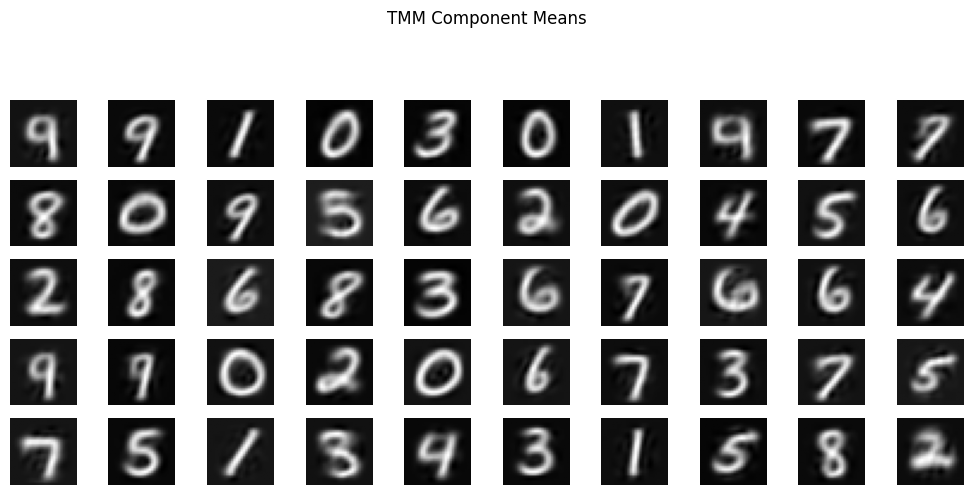

In [81]:
tmm.plot_components(pca)


Test Accuracy (TMM): 81.24%
Adjusted Rand Index (ARI) on Test Set: 0.6658


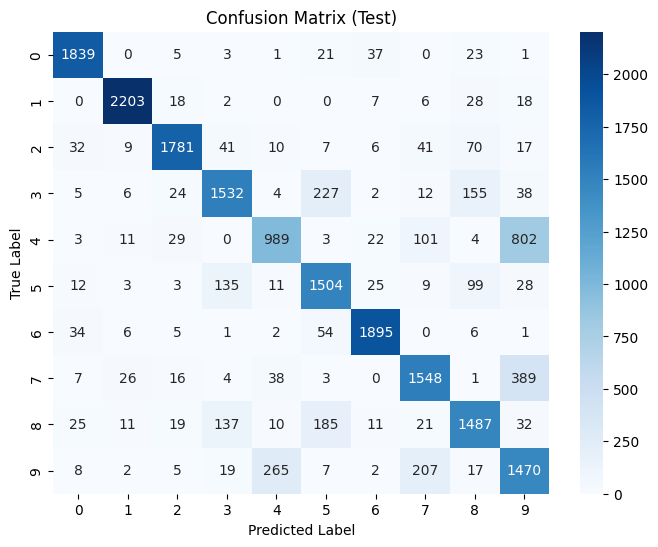

In [82]:
y_test_pred = tmm.predict(X_test)

y_test_mapped = np.array([label_map.get(cluster, -1) for cluster in y_test_pred])

test_accuracy = accuracy_score(y_test, y_test_mapped)
print(f"\nTest Accuracy (TMM): {test_accuracy * 100:.2f}%")

ari_test = adjusted_rand_score(y_test, y_test_mapped)
print(f"Adjusted Rand Index (ARI) on Test Set: {ari_test:.4f}")

conf_mat_test = confusion_matrix(y_test, y_test_mapped, labels=np.arange(10))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test)")
plt.show()

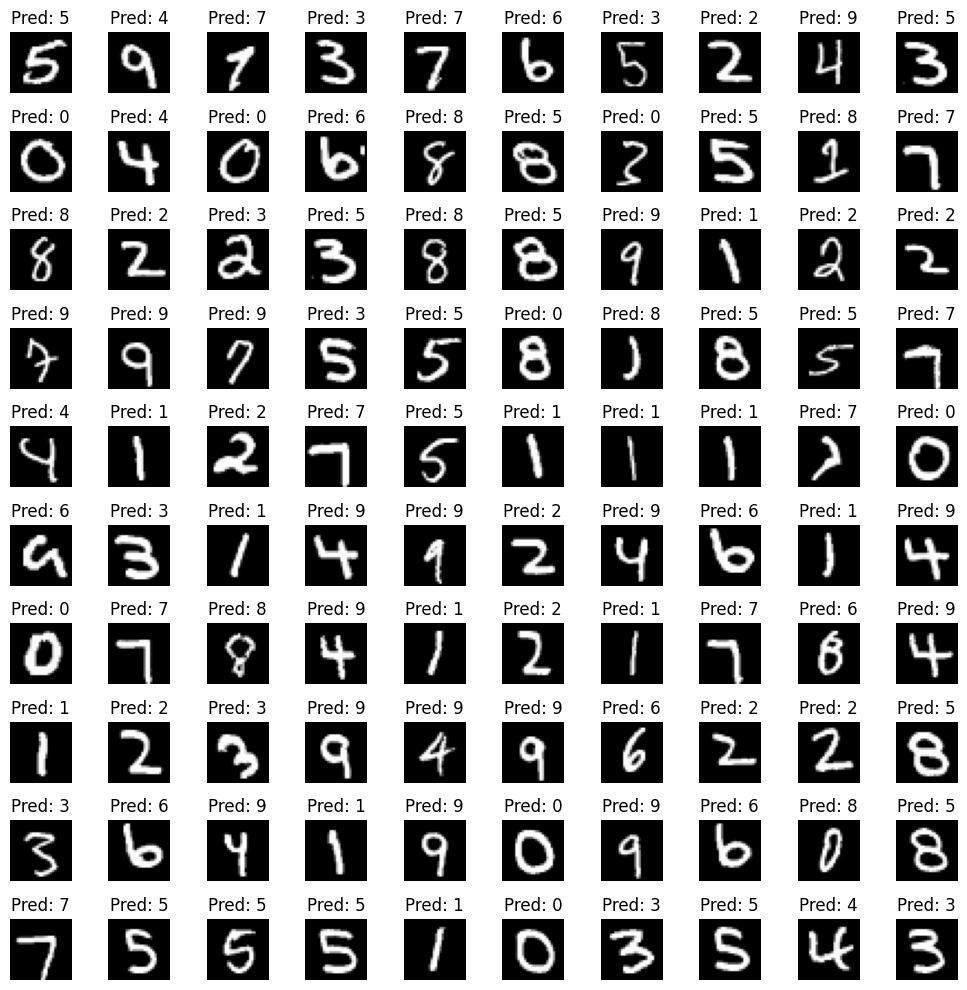

In [84]:
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(X_test_raw[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {y_test_mapped[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()



Training TMM for digit 0


Training TMM: 100%|██████████| 100/100 [00:01<00:00, 97.41it/s]



Training TMM for digit 1


Training TMM: 100%|██████████| 100/100 [00:01<00:00, 79.27it/s]



Training TMM for digit 2


Training TMM: 100%|██████████| 100/100 [00:00<00:00, 100.27it/s]



Training TMM for digit 3


Training TMM: 100%|██████████| 100/100 [00:01<00:00, 92.41it/s]



Training TMM for digit 4


Training TMM: 100%|██████████| 100/100 [00:01<00:00, 96.90it/s]



Training TMM for digit 5


Training TMM: 100%|██████████| 100/100 [00:00<00:00, 107.05it/s]



Training TMM for digit 6


Training TMM: 100%|██████████| 100/100 [00:01<00:00, 97.26it/s]



Training TMM for digit 7


Training TMM: 100%|██████████| 100/100 [00:01<00:00, 91.72it/s]



Training TMM for digit 8


Training TMM: 100%|██████████| 100/100 [00:01<00:00, 98.03it/s]



Training TMM for digit 9


Training TMM: 100%|██████████| 100/100 [00:01<00:00, 90.99it/s]



Ensemble TMM Accuracy: 0.9296
Adjusted Rand Index (ARI): 0.8534


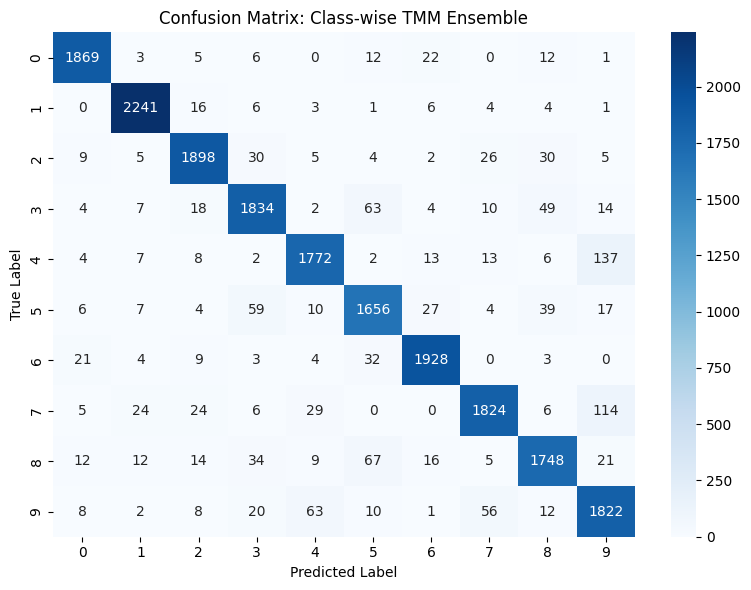

In [85]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration
n_components_per_class = 10  # Number of Student-t components per class
num_classes = 10
classwise_tmms = {}

# Step 1: Train one TMM per class
for digit in range(num_classes):
    print(f"\nTraining TMM for digit {digit}")
    X_class = X_train[y_train == digit]
    
    tmm = StudentTMixtureModel(n_components=n_components_per_class, max_iter=100, verbose=False)
    tmm.fit(X_class)
    
    classwise_tmms[digit] = tmm

# Step 2: Predict labels for test data
log_likelihoods = np.zeros((len(X_test), num_classes))  # shape: [num_samples, num_classes]

# for digit, tmm in classwise_tmms.items():
#     log_probs = np.zeros((X_test.shape[0], tmm.K))
#     for k in range(tmm.K):
#         log_probs[:, k] = np.log(tmm.pi[k] + 1e-10) + tmm._student_t_log_pdf(X_test, tmm.mu[k], tmm.var[k])
#     log_likelihoods[:, digit] = np.logaddexp.reduce(log_probs, axis=1)  # log-sum-exp trick


X_test_np = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test

for digit, tmm in classwise_tmms.items():
    log_probs = np.zeros((X_test_np.shape[0], tmm.K))
    for k in range(tmm.K):
        log_probs[:, k] = (
            np.log(tmm.pi[k] + 1e-10)
            + tmm._student_t_log_pdf(X_test_np, tmm.mu[k], tmm.var[k])
        )
    log_likelihoods[:, digit] = np.logaddexp.reduce(log_probs, axis=1)


# Final prediction: class with max log-likelihood
y_pred = np.argmax(log_likelihoods, axis=1)

# Step 3: Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\nEnsemble TMM Accuracy: {acc:.4f}")

ari = adjusted_rand_score(y_test, y_pred)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Class-wise TMM Ensemble')
plt.tight_layout()
plt.show()


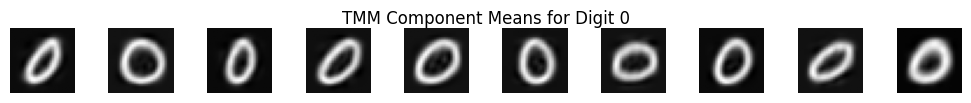

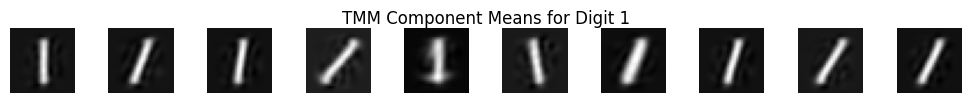

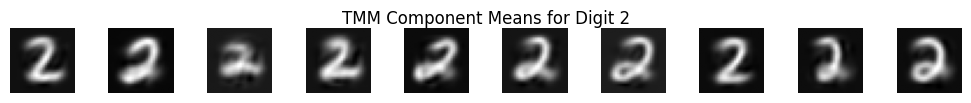

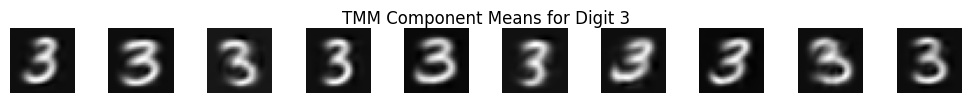

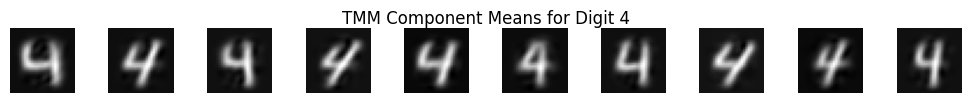

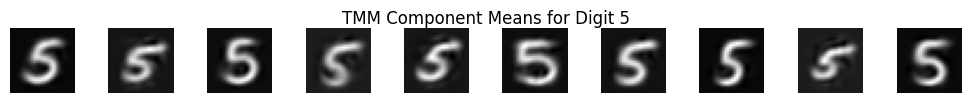

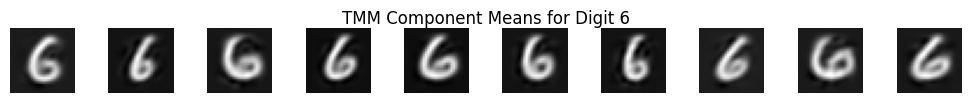

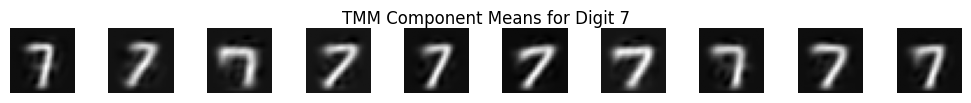

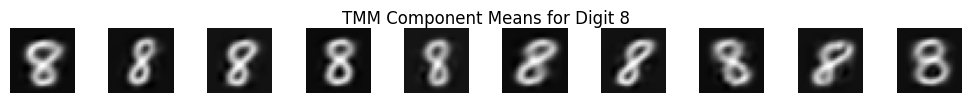

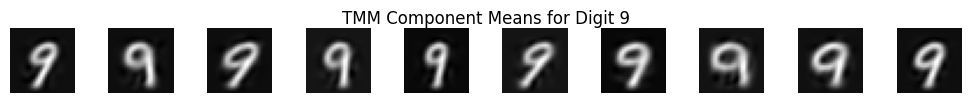

In [86]:
for digit in range(num_classes):
    tmm = classwise_tmms[digit]
    tmm.plot_components(pca, title = 'TMM Component Means for Digit {}'.format(digit))

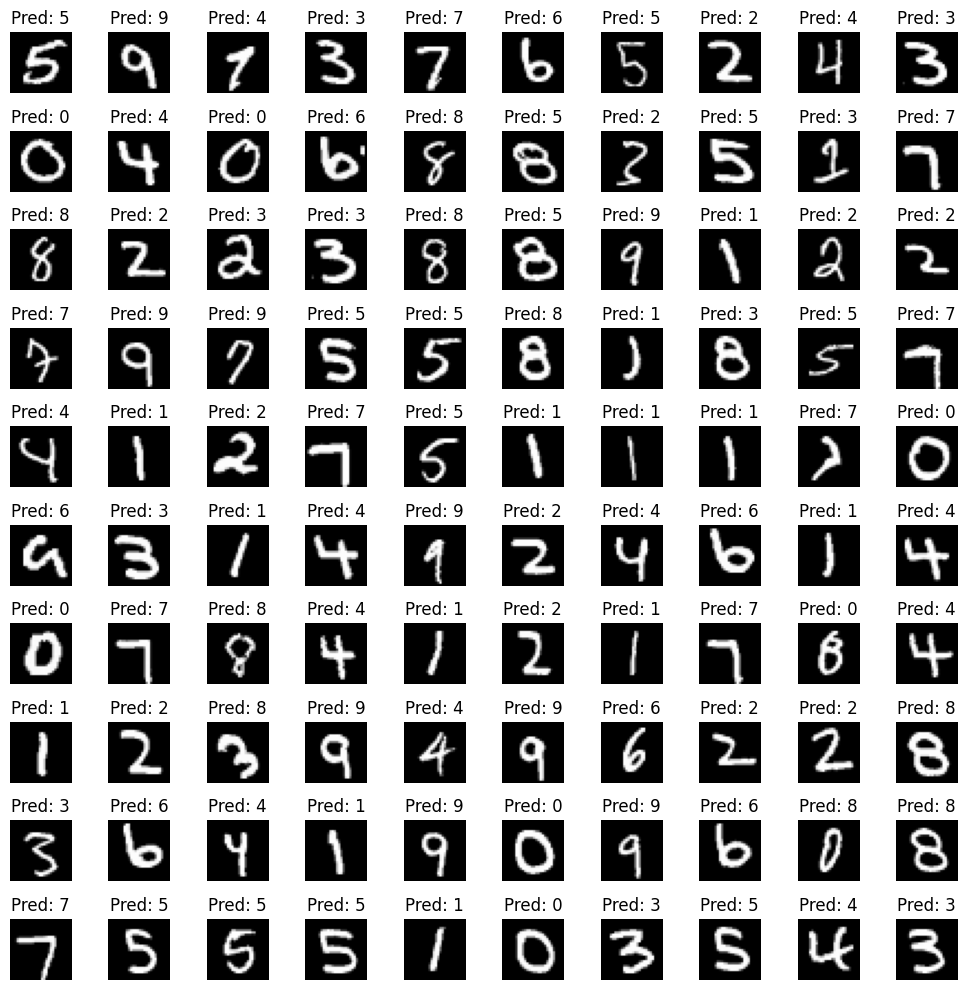

In [88]:
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(X_test_raw[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {y_pred[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
